In [1]:
import os
import ast
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import constants

In [2]:
def summarize(path, fname, name):
    model_meta = pd.read_csv(os.path.join(path, fname))
    def replace(x):
        try:
            return ast.literal_eval(x)
        except:
            return x
    for col in ['pretrain_train_losses', 'pretrain_valid_losses', 'pretrain_train_acc', 'pretrain_valid_acc', 'pretrain_grad_norm',
                'train_losses', 'valid_losses', 'train_acc', 'valid_acc', 'grad_norm']:
        try:
            model_meta[col] = model_meta[col].apply(replace)
        except:
            pass

    model_meta['epochs'] = model_meta['train_losses'].apply(len)
    model_meta['final_train_loss'] = model_meta['train_losses'].apply(lambda x: x[-1])
    model_meta['final_grad_norm'] = model_meta['grad_norm'].apply(lambda x: x[-1])
    model_meta = model_meta.assign(approach=name)

    return model_meta

In [12]:
def read_cnn_results(root_dir, exp_dir, subject=None):
    args = exp_dir.split('_')[1:]
    df = summarize(os.path.join(root_dir, exp_dir, f's_{subject}' if subject is not None else ''), 'trial_results.csv', 'eegnet')

    df = df.assign(impute=args[0])
    df = df.assign(F1=int(args[1].split('-')[0]))
    df = df.assign(D=int(args[2].split('-')[0]))
    df = df.assign(F2=int(args[3].split('-')[0]))
    
    return df

In [70]:
all_model_df = pd.DataFrame()

root_dir = os.path.join(constants.RESULTS_DIR,
                        'motor_LR', 'spatiotemporal_cnn', 'rs', 'max_abs_scale',
                        '4_montages', 'cropped', 
                        'pretrain_montage_viable_chan')

subject = '154'

for d in os.listdir(root_dir):
    try:
        df = read_cnn_results(root_dir, d, subject if subject is not None else None)
        all_model_df = all_model_df.append(df, ignore_index=True)
    except OSError as e:
        print(e)
    
train_cols = ['train_accuracy', 'train_precision', 'train_recall', 'train_f1']
valid_cols = ['valid_accuracy', 'valid_precision', 'valid_recall', 'valid_f1']
test_cols = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']

In [71]:
all_model_df.columns

Index(['cv_iter', 'Status', 'epoch_early_stop', 'final_test_accuracy',
       'final_test_auc', 'final_test_f1', 'final_test_loss',
       'final_test_precision', 'final_test_recall', 'final_train_accuracy',
       'final_train_auc', 'final_train_f1', 'final_train_precision',
       'final_train_recall', 'final_valid_accuracy', 'final_valid_auc',
       'final_valid_f1', 'final_valid_precision', 'final_valid_recall',
       'grad_norm', 'montage', 'subject', 'test_accuracy', 'test_auc',
       'test_f1', 'test_precision', 'test_recall', 'train_acc',
       'train_accuracy', 'train_auc', 'train_f1', 'train_losses',
       'train_precision', 'train_recall', 'valid_acc', 'valid_accuracy',
       'valid_auc', 'valid_f1', 'valid_losses', 'valid_precision',
       'valid_recall', 'epochs', 'final_train_loss', 'final_grad_norm',
       'approach', 'impute', 'F1', 'D', 'F2'],
      dtype='object')

In [72]:
montage_order = constants.PAIRED_MONTAGES

In [73]:
all_model_df.F2.unique()

array([32])

In [74]:
F1 = 12
D = 8
F2 = 32

### Test performance metrics (barplot)

In [75]:
melt_test = pd.melt(all_model_df,
                    id_vars = ['F1', 'D', 'F2', 'montage'],
                    value_vars = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1'],
                    var_name = 'metric')
melt_test.loc[:, 'metric'] = melt_test.loc[:, 'metric'].apply(lambda x: x.split('_')[1].capitalize())

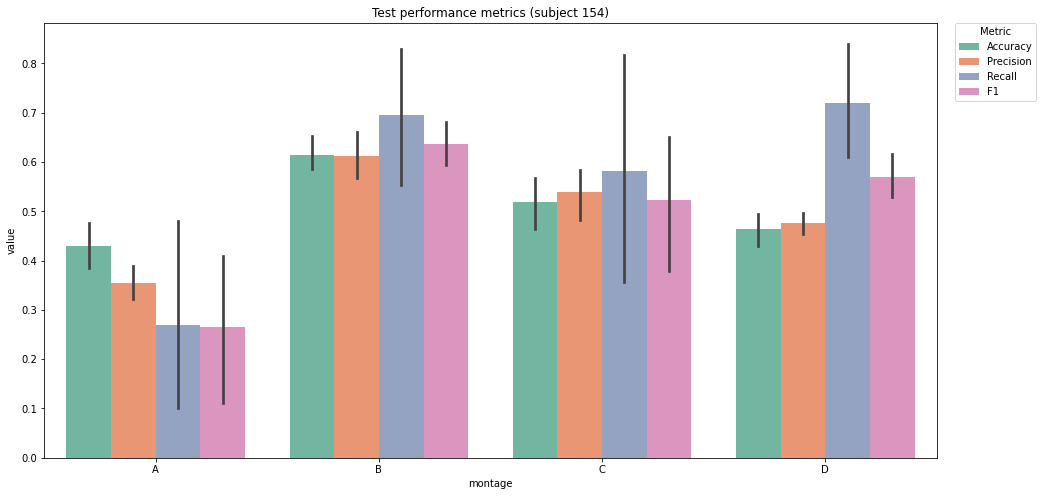

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=melt_test[(melt_test['F1'] == F1) &
                           (melt_test['D'] == D) & 
                           (melt_test['F2'] == F2)],
            x='montage', y='value', hue='metric', palette='Set2', ax=ax, order=montage_order)
plt.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title('Test performance metrics (subject 154)');

### Early stopping (validation loss) test accuracy

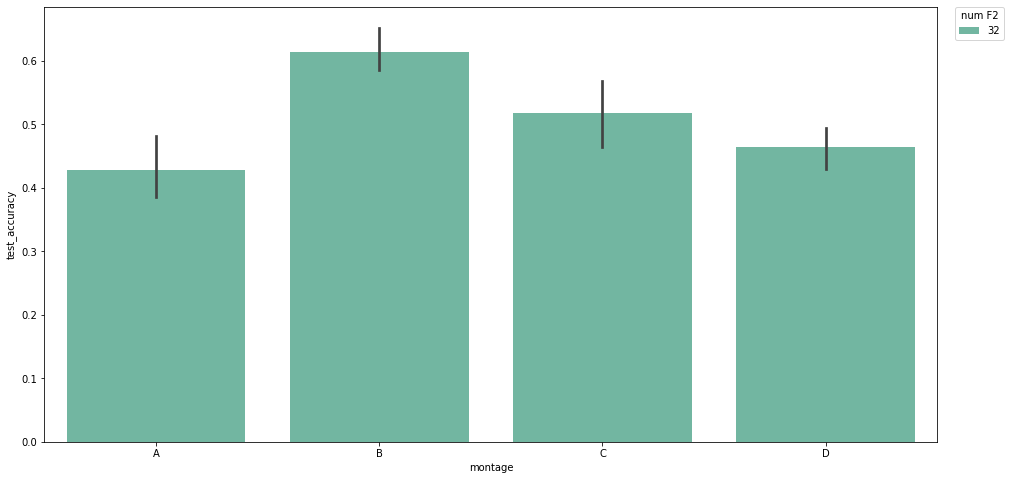

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=all_model_df[(all_model_df['F1'] == F1) & 
                              (all_model_df['D'] == D)],
            x='montage', y='test_accuracy', hue='F2', palette='Set2', ax=ax, order=montage_order)
plt.legend(title='num F2', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title(f'');

### Final test accuracy

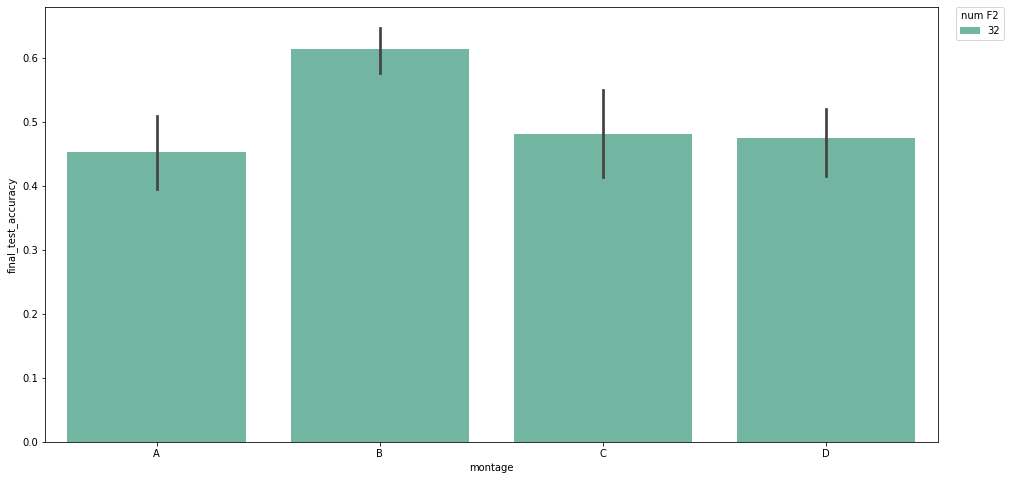

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=all_model_df[(all_model_df['F1'] == F1) & 
                              (all_model_df['D'] == D)],
            x='montage', y='final_test_accuracy', hue='F2', palette='Set2', ax=ax, order=montage_order)
plt.legend(title='num F2', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title(f'');

### Early stopping (validation loss) train accuracy

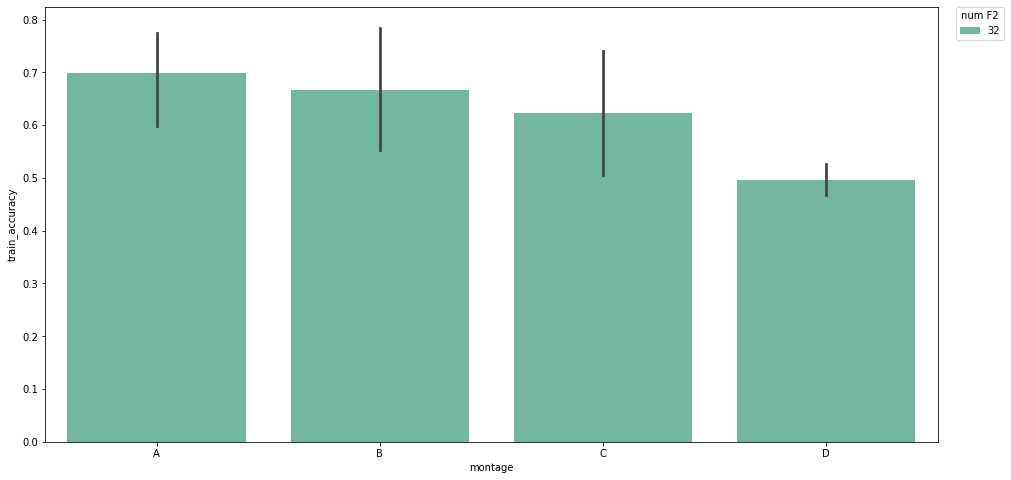

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=all_model_df[(all_model_df['F1'] == F1) & 
                              (all_model_df['D'] == D)],
            x='montage', y='train_accuracy', hue='F2', palette='Set2', ax=ax, order=montage_order)
plt.legend(title='num F2', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title(f'');

### Final train accuracy

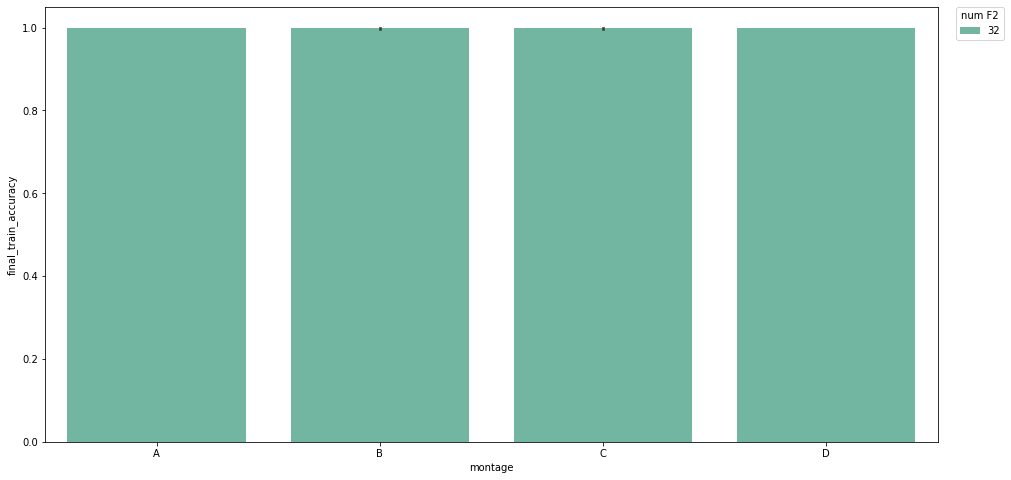

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=all_model_df[(all_model_df['F1'] == F1) & 
                              (all_model_df['D'] == D)],
            x='montage', y='final_train_accuracy', hue='F2', palette='Set2', ax=ax, order=montage_order)
plt.legend(title='num F2', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.title(f'');

In [81]:
output_df = all_model_df[(all_model_df['F1'] == F1) &
                         (all_model_df['D'] == D) & 
                         (all_model_df['F2'] == F2)].groupby('montage').mean()
output_df[test_cols + valid_cols + train_cols + ['epochs']].round(3)

,test_accuracy,test_precision,test_recall,test_f1,valid_accuracy,valid_precision,valid_recall,valid_f1,train_accuracy,train_precision,train_recall,train_f1,epochs
montage,,,,,,,,,,,,,
A,0.429,0.354,0.270,0.264,0.506,0.588,0.450,0.425,0.699,0.680,0.731,0.703,300
B,0.614,0.613,0.695,0.637,0.608,0.625,0.687,0.633,0.667,0.670,0.701,0.685,300
C,0.518,0.539,0.583,0.523,0.557,0.541,0.600,0.546,0.624,0.624,0.672,0.647,300
D,0.465,0.477,0.720,0.569,0.468,0.489,0.738,0.584,0.495,0.507,0.572,0.537,300


In [82]:
output_df = output_df[['F1', 'D', 'F2'] + test_cols].round(3)
output_df.reset_index(inplace=True)
output_df.set_index = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
print(output_df.to_latex(index=False,
                         header=['Montage', 'F1', 'D', 'F2', 'Accuracy', 'Precision', 'Recall', 'F1']))

\begin{tabular}{lrrrrrrr}
\toprule
Montage &  F1 &  D &  F2 & Accuracy & Precision & Recall &     F1 \\
\midrule
      A &  12 &  8 &  32 &    0.429 &     0.354 &  0.270 &  0.264 \\
      B &  12 &  8 &  32 &    0.614 &     0.613 &  0.695 &  0.637 \\
      C &  12 &  8 &  32 &    0.518 &     0.539 &  0.583 &  0.523 \\
      D &  12 &  8 &  32 &    0.465 &     0.477 &  0.720 &  0.569 \\
\bottomrule
\end{tabular}



## Train/Valid Losses

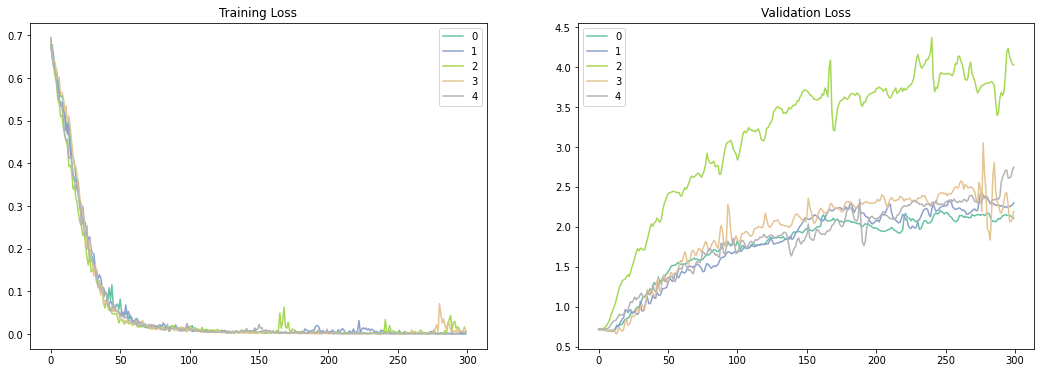

In [83]:
F1 = 12
D = 8
F2 = 32
montage = 'B'

subset_df = all_model_df[(all_model_df['F1'] == F1) &
                         (all_model_df['D'] == D) & 
                         (all_model_df['F2'] == F2) & 
                         (all_model_df['montage'] == montage)]

n = len(subset_df)
colors = plt.cm.Set2(np.linspace(0, 1, n))

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
for i, idx in enumerate(subset_df.index):
    ax[0].plot(subset_df.loc[idx, 'train_losses'], color=colors[i])
    ax[1].plot(subset_df.loc[idx, 'valid_losses'], color=colors[i])
    ax[0].set_title('Training Loss')
    ax[1].set_title('Validation Loss')
    if subject is not None:
        ax[0].legend(subset_df.cv_iter.unique())
        ax[1].legend(subset_df.cv_iter.unique())
    else:
        ax[0].legend(subset_df.subject.unique())
        ax[1].legend(subset_df.subject.unique())

## Train/Valid Accuracies

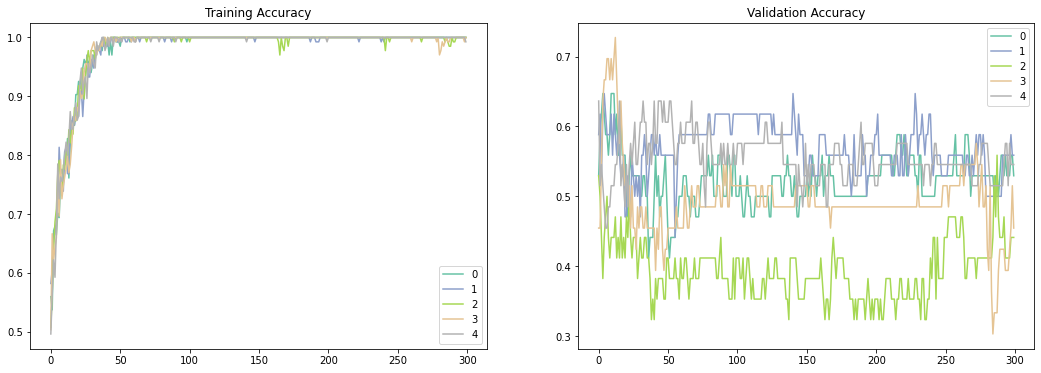

In [84]:
subset_df = all_model_df[(all_model_df['F1'] == F1) &
                         (all_model_df['D'] == D) & 
                         (all_model_df['F2'] == F2) & 
                         (all_model_df['montage'] == montage)]

n = len(subset_df)
colors = plt.cm.Set2(np.linspace(0, 1, n))

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
for i, idx in enumerate(subset_df.index):
    ax[0].plot(subset_df.loc[idx, 'train_acc'], color=colors[i])
    ax[1].plot(subset_df.loc[idx, 'valid_acc'], color=colors[i])
    ax[0].set_title('Training Accuracy')
    ax[1].set_title('Validation Accuracy')
    if subject is not None:
        ax[0].legend(subset_df.cv_iter.unique())
        ax[1].legend(subset_df.cv_iter.unique())
    else:
        ax[0].legend(subset_df.subject.unique())
        ax[1].legend(subset_df.subject.unique())

## Gradient Norm

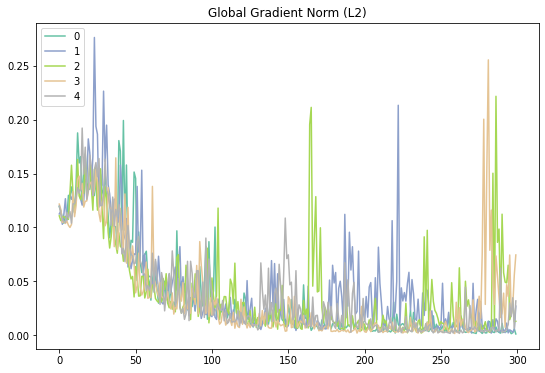

In [85]:
subset_df = all_model_df[(all_model_df['F1'] == F1) &
                         (all_model_df['D'] == D) & 
                         (all_model_df['F2'] == F2) & 
                         (all_model_df['montage'] == montage)]

n = len(subset_df)
colors = plt.cm.Set2(np.linspace(0, 1, n))

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
for i, idx in enumerate(subset_df.index):
    ax.plot(subset_df.loc[idx, 'grad_norm'], color=colors[i])
    ax.set_title('Global Gradient Norm (L2)')
    if subject is not None:
        ax.legend(subset_df.cv_iter.unique())
    else:
        ax.legend(subset_df.subject.unique())

## View predictions

In [91]:
F1 = 12
D = 8
F2 = 32
montage = 'B'
phase = 'test'
final = False
cv_iter = 0

exp_dir = f'eegnet_zero_{F1}-F1_{D}-D_{F2}-F2'

def aggregate_predictions(root_dir, exp_dir, subject, montage, phase):
    
    out_df = pd.DataFrame()
    for i in range(5):
        df = pd.read_parquet(
            os.path.join(root_dir, exp_dir,
                         f's_{subject}' if subject is not None else '',
                         'final_predictions' if final else 'predictions',
                         f'{subject}_{montage}_{phase}_{i}.parquet'))
        out_df = out_df.append(df, ignore_index=True)
        
    return out_df

pred_df = aggregate_predictions(root_dir, exp_dir, subject, montage, phase)
pred_df['pred'] = pred_df['pred'].astype(np.float32)
subset_df = pred_df[pred_df['cv_iter'] == cv_iter]
subset_df

,subject_id,montage,cv_iter,true,pred,prob
0,154,B,0,0.0,0.0,0.483733
1,154,B,0,1.0,1.0,0.562270
2,154,B,0,0.0,0.0,0.358321
3,154,B,0,1.0,1.0,0.621470
4,154,B,0,0.0,1.0,0.626623
5,154,B,0,1.0,1.0,0.630459
6,154,B,0,0.0,1.0,0.647344
7,154,B,0,0.0,0.0,0.344613
8,154,B,0,1.0,1.0,0.555878
9,154,B,0,0.0,0.0,0.490881


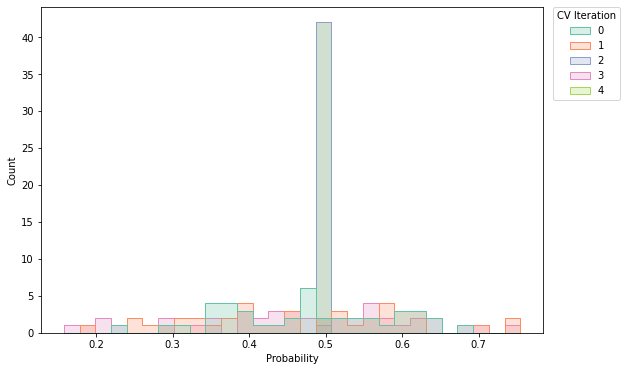

In [92]:
def move_legend(ax, new_title, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    if new_title is not None:
        title = new_title
    else:
        title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

sns.histplot(data=pred_df, x='prob', hue='cv_iter', element='step', fill=True, palette='Set2', ax=ax)
move_legend(ax, new_title='CV Iteration', bbox_to_anchor=(1.02, 1), new_loc=2, borderaxespad=0.)
ax.set_xlabel('Probability');

In [93]:
from sklearn.metrics import accuracy_score

accuracy_score(subset_df['true'], subset_df['pred'])

0.6190476190476191

In [94]:
np.bincount(subset_df.true.values.astype(int))

array([21, 21])

In [95]:
subset_df.pred.unique()

array([0., 1.], dtype=float32)

# Save cross-subject results

In [67]:
all_subject_df = pd.DataFrame()

root_dir = os.path.join(constants.RESULTS_DIR,
                        'motor_LR', 'chan_avg_transformer', 'rs',
                        'bandpass_only', 'max_abs_scale',
                        '4_montages', 'no_early_stop', 'cropped', 
                        'pretrain_montage_pool', 'all')
subjects = constants.SUBSET_SUBJECT_IDS

for d in os.listdir(root_dir):
    for subject in subjects:
        try:
            df = read_transformer_results(root_dir, d, subject if subject is not None else None)
            df.loc[:, 'subject_id'] = subject
            all_subject_df = all_subject_df.append(df, ignore_index=True)
        except OSError as e:
            pass

all_subject_df.loc[:, 'approach'] = 'Channel-pool Transformer (pretrain montage)'

In [68]:
all_subject_df.subject_id.unique()

array(['154', '534', '152', '527', '505', '127'], dtype=object)

In [69]:
n_layers = 1
n_heads = 4
factor = 3
d_model = 32

all_subject_df = all_subject_df[(all_subject_df['n_layers'] == n_layers) &
                                (all_subject_df['n_heads'] == n_heads) & 
                                (all_subject_df['factor'] == factor) & 
                                (all_subject_df['d_model'] == d_model)]

In [70]:
all_subject_df.to_parquet(
    os.path.join(constants.RESULTS_DIR, 'motor_LR', 'approach_tables', 'chan_pool_transformer_pretrain_montage.parquet'))

In [71]:
df = pd.read_parquet(os.path.join(constants.RESULTS_DIR, 'motor_LR', 'approach_tables', 'chan_pool_transformer_pretrain_montage.parquet'))
df.columns

Index(['cv_iter', 'Status', 'final_test_accuracy', 'final_test_auc',
       'final_test_f1', 'final_test_loss', 'final_test_precision',
       'final_test_recall', 'final_train_accuracy', 'final_train_auc',
       'final_train_f1', 'final_train_precision', 'final_train_recall',
       'final_valid_accuracy', 'final_valid_auc', 'final_valid_f1',
       'final_valid_precision', 'final_valid_recall', 'grad_norm', 'montage',
       'pretrain_final_test_accuracy', 'pretrain_final_test_auc',
       'pretrain_final_test_f1', 'pretrain_final_test_loss',
       'pretrain_final_test_precision', 'pretrain_final_test_recall',
       'pretrain_final_train_accuracy', 'pretrain_final_train_auc',
       'pretrain_final_train_f1', 'pretrain_final_train_precision',
       'pretrain_final_train_recall', 'pretrain_final_valid_accuracy',
       'pretrain_final_valid_auc', 'pretrain_final_valid_f1',
       'pretrain_final_valid_precision', 'pretrain_final_valid_recall',
       'pretrain_grad_norm', 'pretrai